## Recurrent Neural Networks (RNN)


# Parameter Choice
<table style="width:80%">
<tr>
<th>Paramter</th>
<th>Value</th>
<th>Understanding/Observation</th>
</tr>
<tr>
<td>Window size</td>
<td>58</td>
<td>Look back period, how many days to capture as a unit, Increasing the window size above 60 could not explain the last 30 days of increase in price.</td>
</tr>
<tr>
<td>Number of epochs</td>
<td>200</td>
<td>Increasing the epochs made the model more deterministic and reduced the loss in validation</td>
</tr>
<tr>
<td>Hidden Units</td>
<td>4</td>
<td>Decreasing the hidden units actually helped when we changed the activation function to tanh + ReLU. With hidden input layer</td>
</tr>
<tr>
<td>Activation Function</td>
<td>tanh + relu</td>
<td>Centering data and manages data in preferable range mapping from (-1 to 1) help capture dynamics, final layer is relu as it maps to (0, inf) which is nature of output price predicted.  </td>
</tr>
<tr>
<td>Batch size</td>
<td>10</td>
<td>Reduced it as the model was not able to generalize the last 30 days of the stock prices where it was struggling to predict. </td>
</tr>
</table>
<br/>
<br/>
<br/>


# Insights
The parameters direct the model to analyze the data by helping it understand the data in terms market and time period.<br/>
#### What does our data mean ?
Batch Size: 10 - Two weeks data per time step<br/>
Window: 58 - Look back 58 days of data to predict the next price<br/>
Epochs: 200 - Build memory to understand the data by looking 200 times<br/>
Hidden Units: 4 - Capture complex insights sooner<br/>
<br/>
Quarter is captured in window size, sprint is defined in batch size
<br/>

# Approach
Initial observations RMSE was 9.xx, gap between test train loss curve, 

1. Update the window to 63 days -> Increase in test RMSE value to 14 - Underpredicted especially the last 30 days -> Learning: Since the test prediction is varying the model needs to capture the dynamics of the stock so it needs less frequent updates or change in params 
2. Update the batch size to avoid frequent updates -> Decrease to 10 - Sudden drops in loss -> Learning: Turning out to be more deterministic in nature so we shall increase epoch to make it more deterministic

3. Debugged to found variance of last 30 days was not accounted by validation of model so reset all the params, increase batch size to be more deterministic and decreased the window size to capture in smaller chunk & changed the number of hidden layer as it was overshooting the values.

4. We got a value of 4.8494 with (58, 200, 10, 5)

5. Refined further by experimenting with activation layer, fixed the tanh for hidden layer but changed the value of the final Dense layer to relu since our prediction values lie in (0, inf). In inclusion to this also decreased the number of layers to obtain a RMSE of 3.47.



### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%pip install pandas_datareader
%pip install tensorflow
%pip install keras
%pip install yfinance
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1210]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

### Model Input

[*********************100%***********************]  1 of 1 completed


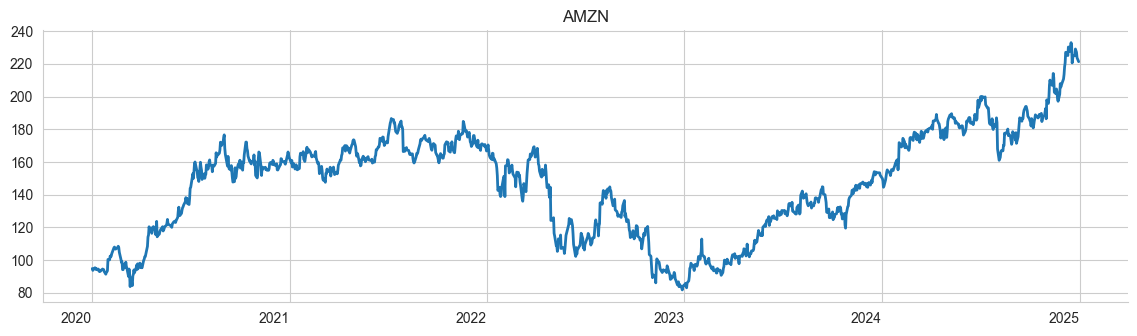

In [1211]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

start_date = datetime(2020,1,1)
end_date = datetime(2024,12,31)
stock_symbol = 'AMZN'
price_type = 'Close'

# Download stock data from yahoo finance
stocks = yf.download(stock_symbol,start_date ,end_date)
stock_price = pd.DataFrame(stocks[price_type])

ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [1212]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(), 
                         index = stock_price.index)

### Model Processing 

In [1213]:
def create_univariate_rnn_data(data, window_size):
    n = len(data) 
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 58
X, y = create_univariate_rnn_data(stocks_scaled, window_size = window_size)

# Train-test split
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']
y_train.shape

n_obs, window_size, n_features = X_train.shape 
# keep the last year for testing
X_test = X['2024':].values.reshape(-1, window_size, 1)
y_test = y['2024':]

In [1214]:
X_train.shape

(948, 58, 1)

In [1215]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(SimpleRNN(hidden_units, input_shape = input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create model and train
rnn = create_RNN(hidden_units = 4, dense_units = 1, input_shape = (window_size, n_features), 
                   activation=['tanh', 'relu'])
rnn.summary()

/Users/bhargavcn/Documents/NorthEastern/NEU Course/SES Course Resources/GENAI/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_107 (SimpleRNN)      │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [1216]:
RNN_training = rnn.fit(X_train, 
                       y_train, 
                       epochs = 200, 
                       batch_size = 10,
                       validation_data = (X_test, y_test),
                       verbose=1)

Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - val_loss: 0.0364
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0308
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0209
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0183
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0155
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0131
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0119
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0072
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

### Model Output

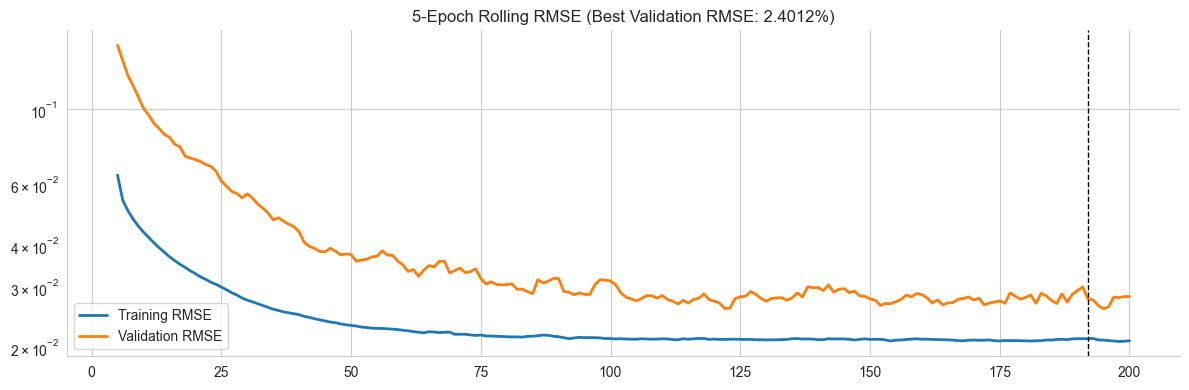

In [1217]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(RNN_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [1218]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0215 | Test RMSE (scaled): 0.0251


In [1219]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train IC: 0.9908 | Test IC: 0.9654


**Rescale Predictions**

In [1220]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [1221]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 3.24 | Test RMSE: 3.79


In [1222]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), 
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on = 'Date')
# remove the suffixes brought by pd.merge()
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

### Visualization

In [1223]:
stock_price

,AMZN,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-03-26,97.774498,95.100632,NaN,95.100632,Train
2020-03-27,95.004997,98.839798,NaN,98.839798,Train
2020-03-30,98.197502,96.123940,NaN,96.123940,Train
2020-03-31,97.486000,98.627121,NaN,98.627121,Train
2020-04-01,95.385002,99.059700,NaN,99.059700,Train
...,...,...,...,...,...
2024-12-23,225.059998,NaN,218.967606,218.967606,Test
2024-12-24,229.050003,NaN,218.503510,218.503510,Test
2024-12-26,227.050003,NaN,221.954102,221.954102,Test


/var/folders/_g/pnkjprqj7z3d7wwtd6jwl2fc0000gn/T/ipykernel_7293/1075208338.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
/var/folders/_g/pnkjprqj7z3d7wwtd6jwl2fc0000gn/T/ipykernel_7293/1075208338.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

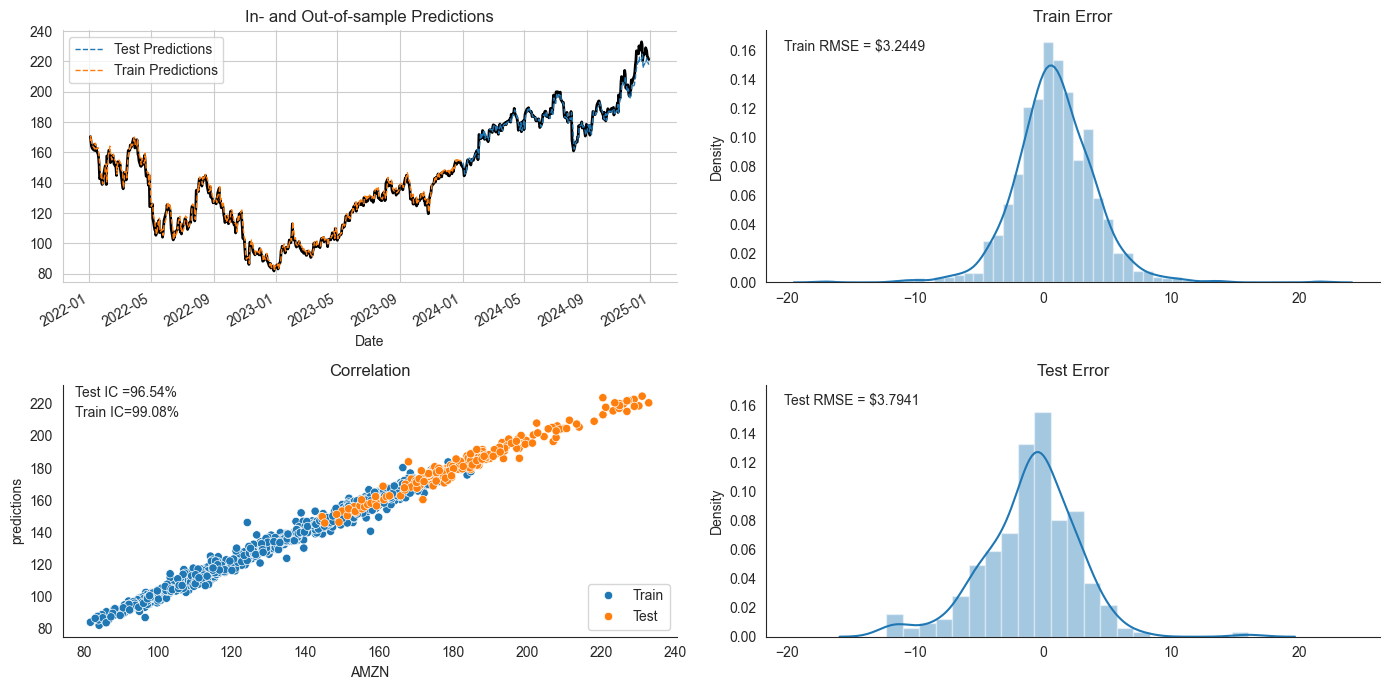

In [1224]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2022':, stock_symbol].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2022':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x = stock_symbol, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()